In [1]:
import sys
import gym
import pylab
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K

EPISODES = 1000

Using TensorFlow backend.


In [2]:
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False
        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # 액터-크리틱 하이퍼파라미터
        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        # 정책신경망과 가치신경망 생성
        self.actor = self.build_actor()
        self.critic = self.build_critic()
        self.actor_updater = self.actor_optimizer()
        self.critic_updater = self.critic_optimizer()

        if self.load_model:
            self.actor.load_weights("./save_model/cartpole_actor_trained.h5")
            self.critic.load_weights("./save_model/cartpole_critic_trained.h5")

    # actor: 상태를 받아 각 행동의 확률을 계산
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        actor.summary()
        return actor

    # critic: 상태를 받아서 상태의 가치를 계산
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        critic.summary()
        return critic

    # 정책신경망의 출력을 받아 확률적으로 행동을 선택
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # 정책신경망을 업데이트하는 함수
    def actor_optimizer(self):
        action = K.placeholder(shape=[None, self.action_size])
        advantage = K.placeholder(shape=[None, ])

        action_prob = K.sum(action * self.actor.output, axis=1)
        cross_entropy = K.log(action_prob) * advantage
        loss = -K.sum(cross_entropy)

        optimizer = Adam(lr=self.actor_lr)
        updates = optimizer.get_updates(self.actor.trainable_weights, [], loss)
        train = K.function([self.actor.input, action, advantage], [],
                           updates=updates)
        return train

    # 가치신경망을 업데이트하는 함수
    def critic_optimizer(self):
        target = K.placeholder(shape=[None, ])

        loss = K.mean(K.square(target - self.critic.output))

        optimizer = Adam(lr=self.critic_lr)
        updates = optimizer.get_updates(self.critic.trainable_weights, [], loss)
        train = K.function([self.critic.input, target], [], updates=updates)

        return train

    # 각 타임스텝마다 정책신경망과 가치신경망을 업데이트
    def train_model(self, state, action, reward, next_state, done):
        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        act = np.zeros([1, self.action_size])
        act[0][action] = 1

        # 벨만 기대 방정식를 이용한 어드벤티지와 업데이트 타깃
        if done:
            advantage = reward - value
            target = [reward]
        else:
            advantage = (reward + self.discount_factor * next_value) - value
            target = reward + self.discount_factor * next_value

        self.actor_updater([state, act, advantage])
        self.critic_updater([state, target])


W0914 10:02:36.040968  8840 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0914 10:02:36.053894  8840 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0914 10:02:36.056888  8840 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0914 10:02:36.127698  8840 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1702: The name tf.log is deprecated. Please use tf.math.log instead.

W0914 10:02:36.186541  8840 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\si

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 745
Trainable params

SystemExit: 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


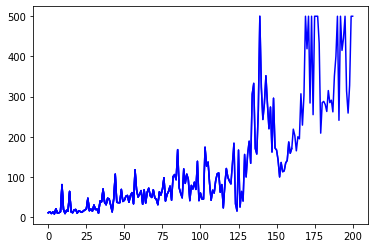

In [3]:
# CartPole-v1 환경, 최대 타임스텝 수가 500
env = gym.make('CartPole-v1')
# 환경으로부터 상태와 행동의 크기를 받아옴
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# 액터-크리틱(A2C) 에이전트 생성
agent = A2CAgent(state_size, action_size)

scores, episodes = [], []

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        if agent.render:
            env.render()

        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # 에피소드가 중간에 끝나면 -100 보상
        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        state = next_state

        if done:
            # 에피소드마다 학습 결과 출력
            score = score if score == 500.0 else score + 100
            scores.append(score)
            episodes.append(e)
            if e%40 == 0:
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./graph/cartpole_a2c_"+str(e)+".png")
            print("episode:", e, "  score:", score)

            # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                agent.actor.save_weights("./model/cartpole_actor_"+str(e)+".h5")
                agent.critic.save_weights(
                    "./model/cartpole_critic_"+str(e)+".h5")
                sys.exit()